In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import curve_fit
import pandas as pd
import xlrd
import typing


In [2]:
def correlation(t, A, B, C):
    y = A*(np.exp(-2*B*t)) + C
    return y


In [3]:
def relaxationrate(filename, filetype, Cutoff, Which_Side, Angle):
    
    if filetype == 'excel':
        data = pd.read_excel(filename)
    if filetype == 'csv':
        data = pd.read_csv(filename, encoding= 'unicode_escape')
    
    xlabel = data[data.columns[0]][0]
    ylabel = data[data.columns[1]][0]
    
    if Which_Side == 'Left':
        Time = data[data.columns[0]][1:(Cutoff+1)]
        Correlation = data[data.columns[1]][1:(Cutoff+1)]
    
    if Which_Side == 'Right':
        Time = data[data.columns[0]][(Cutoff+1):201]
        Correlation = data[data.columns[1]][(Cutoff+1):201]
    
    x=[]
    y=[]
    
    x = np.array(list(map(float, Time)))
    y = np.array(list(map(float, Correlation)))
    
    parameters, covariance = curve_fit(correlation, x, y, p0 = [0.1,0.1, 0], bounds = (0, 10) )
    
    best_A = parameters[0]
    best_B = parameters[1]
    best_C = parameters[2]
    #print("A:", best_A)
    print("Relaxation Rate for",Angle,"deg", best_B, "1/microsec")
    print("Offset", best_C)
    
    if Angle == 60:
        Color = 'r'
        Figure = 3
    if Angle == 90:
        Color = 'b'
        Figure = 4
    if Angle == 120:
        Color = 'g'
        Figure = 5
    
    fit_y = correlation(x, best_A, best_B, best_C)
    plt.figure(Figure)
    plt.plot(x, y, 'o',markersize = 2, color = 'k')
    plt.plot(x, fit_y, '-', label = Angle, color = Color)
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylim([-0.03,0.25])
    plt.ylabel(ylabel)
    plt.title(filename)
    plt.legend()
    #plt.savefig(filename,format='png') #saves over original file right now and kills it making it a png, don't uncomment for now
    
    return best_B


In [4]:
def scatteringvec(RefractiveIndex, Angle): 
    
    RI = RefractiveIndex #Refractive Index of the sample
    wavelength = 637 # Units - nm, comes from the wavelength of the laser used in the DLS
    radian = (Angle*np.pi)/180
    
    q = ( 4*np.pi*(RI)*(np.sin(radian/2)) )/(wavelength) #Units 1/nm
    
    print("Scattering Vector 'q' for",Angle, "deg:", q, "1/nm")
    
    return q


In [5]:
def diffusioncoef(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex):
    
    if Which_Side == 'Left':
        print("#####################")
        print('LEFT HALF DATA')
        print("#####################")
    
    if Which_Side == 'Right':
        print("#####################")
        print('RIGHT HALF DATA')
        print("#####################")
    
    q2 = np.zeros(3)
    q2[0] = scatteringvec(RefractiveIndex, 60)**2 #Units 1/nm
    q2[1] = scatteringvec(RefractiveIndex, 90)**2 #Units 1/nm
    q2[2] = scatteringvec(RefractiveIndex, 120)**2 #Units 1/nm
    
    B = np.zeros(3)
    
    B[0] = relaxationrate(sixtydeg_filename, filetype, Cutoff, Which_Side, 60) #Units - 1/microsec
    B[1] = relaxationrate(nintydeg_filename, filetype, Cutoff, Which_Side,  90) #Units - 1/microsec
    B[2] = relaxationrate(onetwentydeg_filename, filetype, Cutoff, Which_Side, 120) #Units - 1/microsec
    
    m, b = np.polyfit(q2, B, 1)
    
    if Which_Side == 'Left':
        plt.figure(1)
        plt.scatter(q2, B)
        plt.plot(q2, m*(q2)+b)
        plt.xlabel("Square Scattering Vector 'q^2' ")
        plt.ylabel("Relaxation Rate")
        plt.title("Diffusion Coefficient LEFT")
        
    if Which_Side == 'Right':
        plt.figure(2)
        plt.scatter(q2, B)
        plt.plot(q2, m*(q2)+b)
        plt.xlabel("Square Scattering Vector 'q^2' ")
        plt.ylabel("Relaxation Rate")
        plt.title("Diffusion Coefficient RIGHT")
    
    D = m
    
    print(" ")
    print("Diffusion Coefficient 'D':",D, "nm^2 / microsec")
    print(" ")
    
    return D


In [6]:
def hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity):
    
    kB = 1.380649*(1e-16) #Units - g*cm^2 / K*s^2
    T = 298.15 #Units - Kelvin, room temperature which should be the temperature of the sample
    D = diffusioncoef(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex)
    D = D*(1e-8) #Units - converting nm^2 / microsec to cm^2 / s
    
    Rh = (kB*T)/(6*np.pi*D*Viscosity)*(1e7) #Units - converting cm to nm (depends a lot on units of viscosity)
    
    print("Hydrodynamic Radius 'Rh':", Rh, "nm")
    print(" ")
    print(" ")
    print(" ")
    
    
    return Rh


#####################
LEFT HALF DATA
#####################
Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate for 60 deg 0.06820068928725191 1/microsec
Offset 0.031017218560427336
Relaxation Rate for 90 deg 0.10335632042517583 1/microsec
Offset 0.024357196810334217
Relaxation Rate for 120 deg 0.12190574613536599 1/microsec
Offset 0.030415013881234958
 
Diffusion Coefficient 'D': 128.2460758647369 nm^2 / microsec
 
Hydrodynamic Radius 'Rh': 3.243497627837833 nm
 
 
 
#####################
RIGHT HALF DATA
#####################
Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate for 60 deg 5.505435214323306e-05 1/microsec
Offset 0.001487510893642891
Relaxation Rate for 90 deg 8.798465399638587e-05 1/mic

17320.86251997042

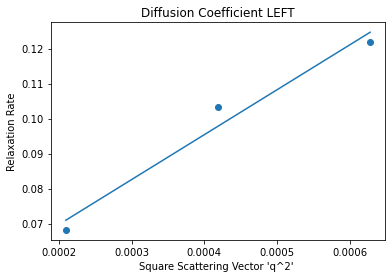

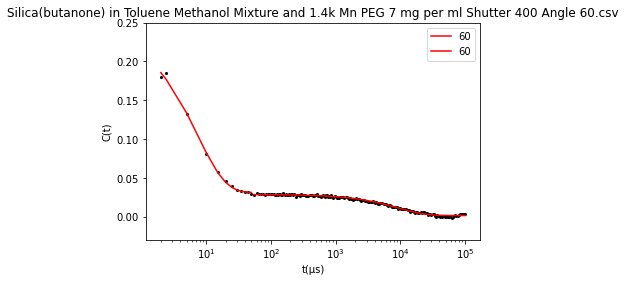

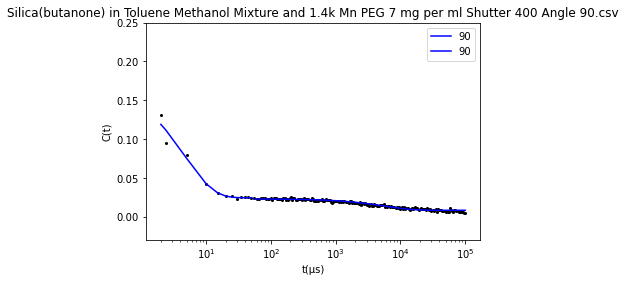

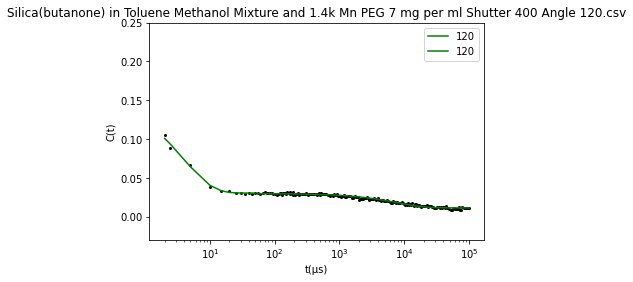

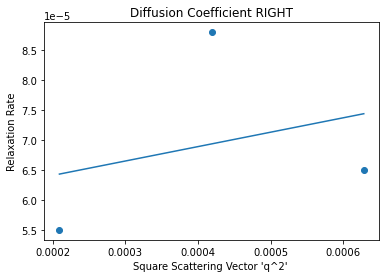

In [7]:

sixtydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 7 mg per ml Shutter 400 Angle 60.csv' 

nintydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 7 mg per ml Shutter 400 Angle 90.csv' 

onetwentydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 7 mg per ml Shutter 400 Angle 120.csv' 
     
filetype = 'csv' 
#either 'excel' or 'csv'

Cutoff = 12

Which_Side = 'Left'
     
RefractiveIndex = 1.467 

Viscosity = 0.00525
#Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
    
    
hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity)

Which_Side = 'Right'

hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity)


#####################
LEFT HALF DATA
#####################
Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate for 60 deg 0.05618921558204692 1/microsec
Offset 0.07964322576863629
Relaxation Rate for 90 deg 0.1109836373037694 1/microsec
Offset 0.05337765818674308
Relaxation Rate for 120 deg 0.11679621771790048 1/microsec
Offset 0.030671519909391144
 
Diffusion Coefficient 'D': 144.7277156009917 nm^2 / microsec
 
Hydrodynamic Radius 'Rh': 2.874127053822817 nm
 
 
 
#####################
RIGHT HALF DATA
#####################
Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate for 60 deg 3.612192300060084e-05 1/microsec
Offset 0.020800407661646994
Relaxation Rate for 90 deg 5.106329115345111e-05 1/micros

4916.42873816931

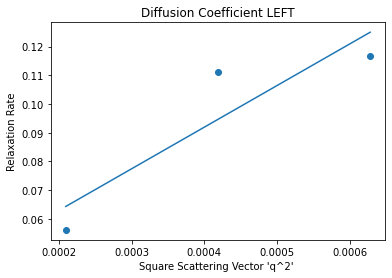

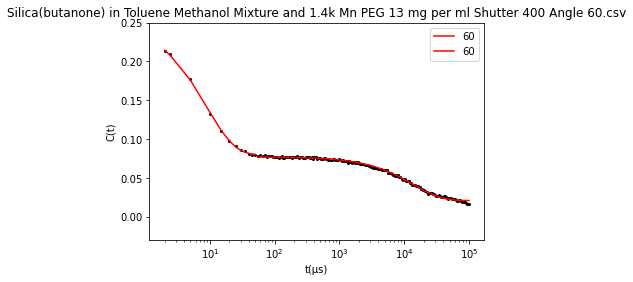

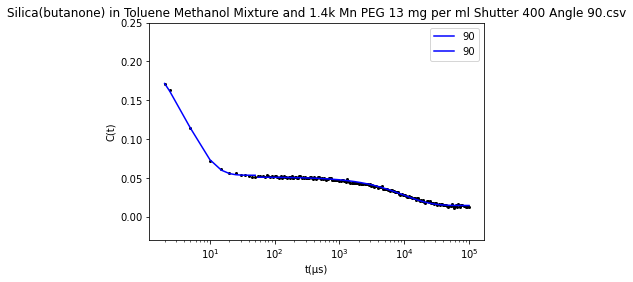

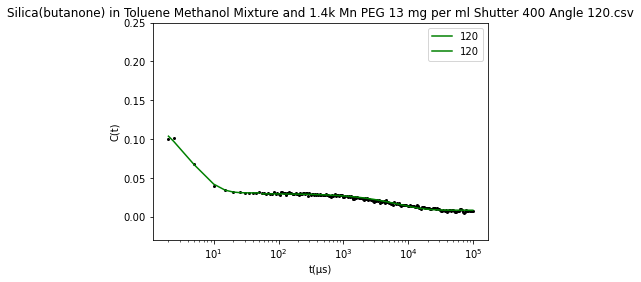

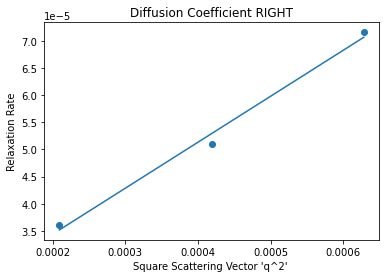

In [8]:
   
sixtydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 13 mg per ml Shutter 400 Angle 60.csv' 

nintydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 13 mg per ml Shutter 400 Angle 90.csv' 

onetwentydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 13 mg per ml Shutter 400 Angle 120.csv' 
     
filetype = 'csv' 
#either 'excel' or 'csv'
         
Cutoff = 12

Which_Side = 'Left'
     
RefractiveIndex = 1.467 

Viscosity = 0.00525
#Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
    
    
hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity)

Which_Side = 'Right'

hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity)


#####################
LEFT HALF DATA
#####################
Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate for 60 deg 0.0673668098701421 1/microsec
Offset 0.06229596733899683
Relaxation Rate for 90 deg 0.11201049295475227 1/microsec
Offset 0.03213252696754964
Relaxation Rate for 120 deg 0.11845109403619586 1/microsec
Offset 0.013724671230000205
 
Diffusion Coefficient 'D': 121.98774877352298 nm^2 / microsec
 
Hydrodynamic Radius 'Rh': 3.4098985105385338 nm
 
 
 
#####################
RIGHT HALF DATA
#####################
Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate for 60 deg 3.629418625508717e-05 1/microsec
Offset 0.0153389631048296
Relaxation Rate for 90 deg 6.0367492140518415e-05 1/micro

3254.897837771288

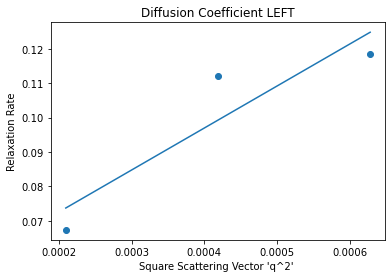

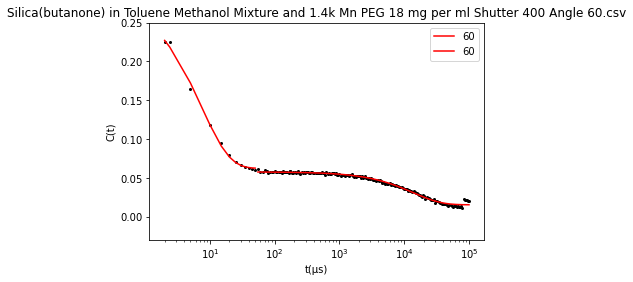

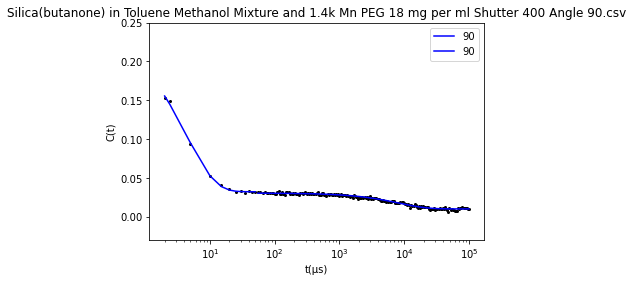

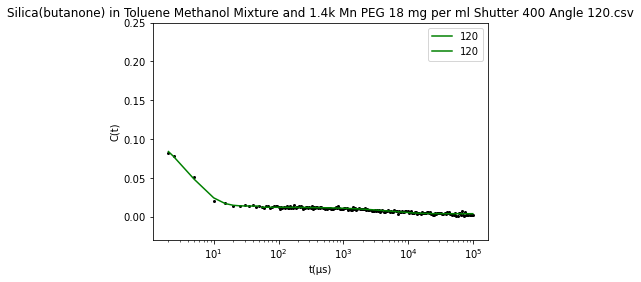

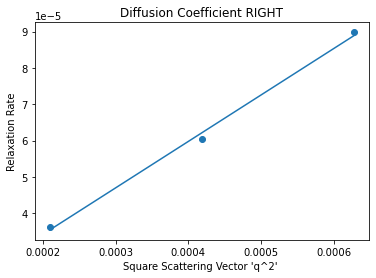

In [9]:

sixtydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 18 mg per ml Shutter 400 Angle 60.csv' 

nintydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 18 mg per ml Shutter 400 Angle 90.csv' 

onetwentydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 18 mg per ml Shutter 400 Angle 120.csv' 

filetype = 'csv' 

#either 'excel' or 'csv'

Cutoff = 12

Which_Side = 'Left'
     
RefractiveIndex = 1.467 

Viscosity = 0.00525
#Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
    
    
hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity)

Which_Side = 'Right'

hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, Cutoff, Which_Side, RefractiveIndex, Viscosity)
